## Data Setup

In [1]:
import torch
from torchvision import transforms, datasets
import time
import copy
import os
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
import torch.optim as optim
import torchvision.models.quantization as qmodels
import torchvision.models as models


batch_size = 32
epochs = 20
stats_lst = []
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}


data_path = Path("data")
image_path = data_path / "EuroSAT_Split"

image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=os.cpu_count())
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\ERDT\AppData\Local\Temp\ipykernel_124268\1115181609.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Functions

In [2]:
## Imshow Function
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(inp)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [3]:
## Imshow Sample
# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
#out = torchvision.utils.make_grid(inputs, nrow=4)

#fig, ax = plt.subplots(1, figsize=(10, 10))
#imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [4]:
## Model Training Function
from tqdm import trange, tqdm_notebook
def train_model(model_name, model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    """
    Support function for model training.
    
    Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in trange(num_epochs, desc = 'Epochs'):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        temp_lst = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train':
                temp_lst +=[model_name, epoch, epoch_loss, epoch_acc]
            elif phase == 'val':
                temp_lst += [epoch_loss, epoch_acc]
                stats_lst.append(temp_lst)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
## Model Visualization Function
def visualize_model(model, rows=3, cols=3):
    was_training = model.training
    model.eval()
    current_row = current_col = 0
    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
            imgs = imgs.cpu()
            lbls = lbls.cpu()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            for jdx in range(imgs.size()[0]):
                imshow(imgs.data[jdx], ax=ax[current_row, current_col])
                ax[current_row, current_col].axis('off')
                ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))
                current_col += 1
                if current_col >= cols:
                    current_row += 1
                    current_col = 0
                if current_row >= rows:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
## Loss & Optimizer Function
def Optimizer_Setup(model: nn.Module, lr=0.01, momentum=0.9):
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    return criterion, optimizer_ft, exp_lr_scheduler

In [7]:
## Save Model Function
from pathlib import Path

def save_model(model: torch.nn.Module, model_name):
    # Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                     exist_ok=True # if models directory already exists, don't error
    )
    
    # Create model save path
    MODEL_NAME = model_name + ".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    # Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
               f=MODEL_SAVE_PATH)

In [8]:
## Export as ONNX function

def export_onnx(model_name, model: torch.nn.Module, batch_size):
    x = torch.randn(batch_size, 3, 64, 64).cpu()
    
    # Export the model
    torch.onnx.export(model,               # model being run
                      x,                         # model input (or a tuple for multiple inputs)
                      "models/"+model_name+".onnx",   # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=13,
                      input_names = ['RGB Image'],   # the model's input names
                      output_names = ['Land Cover Class'] # the model's output names
                     )
    print("Successfully exported model")

## ResNet50

In [22]:
## Model Combination Function
def resnet_features(model_fe,num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

Epochs:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6651 Acc: 0.8239


Epochs:   5%|██▍                                              | 1/20 [04:00<1:16:13, 240.72s/it]

val Loss: 0.5914 Acc: 0.8559

Epoch 1/19
----------
train Loss: 0.5418 Acc: 0.8639


Epochs:  10%|████▉                                            | 2/20 [07:57<1:11:34, 238.56s/it]

val Loss: 0.5499 Acc: 0.8665

Epoch 2/19
----------
train Loss: 0.5174 Acc: 0.8709


Epochs:  15%|███████▎                                         | 3/20 [11:53<1:07:09, 237.05s/it]

val Loss: 0.5190 Acc: 0.8715

Epoch 3/19
----------
train Loss: 0.4867 Acc: 0.8790


Epochs:  20%|█████████▊                                       | 4/20 [15:39<1:02:06, 232.93s/it]

val Loss: 0.4930 Acc: 0.8794

Epoch 4/19
----------
train Loss: 0.4880 Acc: 0.8817


Epochs:  25%|████████████▊                                      | 5/20 [19:38<58:46, 235.11s/it]

val Loss: 0.5707 Acc: 0.8681

Epoch 5/19
----------
train Loss: 0.4601 Acc: 0.8857


Epochs:  30%|███████████████▎                                   | 6/20 [23:24<54:07, 231.95s/it]

val Loss: 0.5424 Acc: 0.8765

Epoch 6/19
----------
train Loss: 0.4423 Acc: 0.8865


Epochs:  35%|█████████████████▊                                 | 7/20 [27:19<50:27, 232.92s/it]

val Loss: 0.5830 Acc: 0.8691

Epoch 7/19
----------
train Loss: 0.3447 Acc: 0.9056


Epochs:  40%|████████████████████▍                              | 8/20 [31:25<47:24, 237.06s/it]

val Loss: 0.4329 Acc: 0.8950

Epoch 8/19
----------
train Loss: 0.3013 Acc: 0.9123


Epochs:  45%|██████████████████████▉                            | 9/20 [35:18<43:13, 235.78s/it]

val Loss: 0.4171 Acc: 0.8954

Epoch 9/19
----------
train Loss: 0.2899 Acc: 0.9155


Epochs:  50%|█████████████████████████                         | 10/20 [39:17<39:29, 236.92s/it]

val Loss: 0.4096 Acc: 0.8957

Epoch 10/19
----------
train Loss: 0.2791 Acc: 0.9180


Epochs:  55%|███████████████████████████▌                      | 11/20 [43:09<35:17, 235.27s/it]

val Loss: 0.4005 Acc: 0.8967

Epoch 11/19
----------
train Loss: 0.2711 Acc: 0.9194


Epochs:  60%|██████████████████████████████                    | 12/20 [47:31<32:28, 243.53s/it]

val Loss: 0.3895 Acc: 0.8946

Epoch 12/19
----------
train Loss: 0.2723 Acc: 0.9176


Epochs:  65%|████████████████████████████████▌                 | 13/20 [51:43<28:42, 246.08s/it]

val Loss: 0.3782 Acc: 0.8970

Epoch 13/19
----------
train Loss: 0.2541 Acc: 0.9199


Epochs:  70%|███████████████████████████████████               | 14/20 [55:35<24:11, 241.89s/it]

val Loss: 0.3792 Acc: 0.8969

Epoch 14/19
----------
train Loss: 0.2446 Acc: 0.9212


Epochs:  75%|█████████████████████████████████████▌            | 15/20 [59:53<20:32, 246.57s/it]

val Loss: 0.3742 Acc: 0.8963

Epoch 15/19
----------
train Loss: 0.2586 Acc: 0.9174


Epochs:  80%|██████████████████████████████████████▍         | 16/20 [1:03:48<16:12, 243.11s/it]

val Loss: 0.3746 Acc: 0.8978

Epoch 16/19
----------
train Loss: 0.2400 Acc: 0.9231


Epochs:  85%|████████████████████████████████████████▊       | 17/20 [1:07:38<11:58, 239.37s/it]

val Loss: 0.3737 Acc: 0.8978

Epoch 17/19
----------
train Loss: 0.2474 Acc: 0.9239


Epochs:  90%|███████████████████████████████████████████▏    | 18/20 [1:11:36<07:57, 238.87s/it]

val Loss: 0.3729 Acc: 0.8987

Epoch 18/19
----------
train Loss: 0.2421 Acc: 0.9225


Epochs:  95%|█████████████████████████████████████████████▌  | 19/20 [1:15:36<03:59, 239.25s/it]

val Loss: 0.3717 Acc: 0.8991

Epoch 19/19
----------
train Loss: 0.2436 Acc: 0.9245


Epochs: 100%|████████████████████████████████████████████████| 20/20 [1:19:32<00:00, 238.63s/it]

val Loss: 0.3709 Acc: 0.8987

Training complete in 79m 33s
Best val Acc: 0.899074


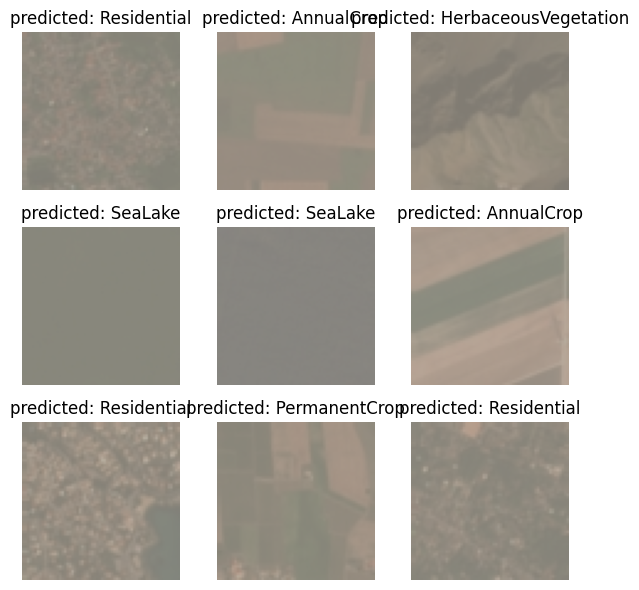

In [23]:
## ResNet50 Quantized
model_name = "ResNet50"
weights = qmodels.ResNet50_QuantizedWeights.DEFAULT
model_rn = qmodels.resnet50(weights=weights, quantize=True)
num_ftrs = model_rn.fc.in_features
new_model = resnet_features(model_rn,num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [24]:
## Save ResNet50
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\ResNet50.pth
Successfully exported model


## MobileNetV3

In [25]:
## Model Combination Function
def mobile_net_features(model_fe, num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.features,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

C:\Users\ERDT\anaconda3\envs\UNetEuroSATRGB\lib\site-packages\torch\ao\quantization\utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
Epochs:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.5525 Acc: 0.8189


Epochs:   5%|██▍                                              | 1/20 [03:39<1:09:33, 219.68s/it]

val Loss: 0.4141 Acc: 0.8622

Epoch 1/19
----------
train Loss: 0.4178 Acc: 0.8570


Epochs:  10%|████▉                                            | 2/20 [07:25<1:07:00, 223.39s/it]

val Loss: 0.3894 Acc: 0.8680

Epoch 2/19
----------
train Loss: 0.3961 Acc: 0.8658


Epochs:  15%|███████▎                                         | 3/20 [11:12<1:03:42, 224.86s/it]

val Loss: 0.3591 Acc: 0.8796

Epoch 3/19
----------
train Loss: 0.3772 Acc: 0.8728


Epochs:  20%|██████████▏                                        | 4/20 [14:54<59:39, 223.75s/it]

val Loss: 0.3662 Acc: 0.8731

Epoch 4/19
----------
train Loss: 0.3651 Acc: 0.8748


Epochs:  25%|████████████▊                                      | 5/20 [18:40<56:08, 224.56s/it]

val Loss: 0.3517 Acc: 0.8813

Epoch 5/19
----------
train Loss: 0.3598 Acc: 0.8761


Epochs:  30%|███████████████▎                                   | 6/20 [22:33<53:04, 227.46s/it]

val Loss: 0.3548 Acc: 0.8774

Epoch 6/19
----------
train Loss: 0.3511 Acc: 0.8783


Epochs:  35%|█████████████████▊                                 | 7/20 [26:12<48:42, 224.78s/it]

val Loss: 0.3478 Acc: 0.8826

Epoch 7/19
----------
train Loss: 0.3344 Acc: 0.8846


Epochs:  40%|████████████████████▍                              | 8/20 [29:50<44:30, 222.57s/it]

val Loss: 0.3323 Acc: 0.8878

Epoch 8/19
----------
train Loss: 0.3269 Acc: 0.8871


Epochs:  45%|██████████████████████▉                            | 9/20 [33:49<41:45, 227.73s/it]

val Loss: 0.3304 Acc: 0.8870

Epoch 9/19
----------
train Loss: 0.3248 Acc: 0.8866


Epochs:  50%|█████████████████████████                         | 10/20 [37:27<37:27, 224.75s/it]

val Loss: 0.3291 Acc: 0.8883

Epoch 10/19
----------
train Loss: 0.3289 Acc: 0.8856


Epochs:  55%|███████████████████████████▌                      | 11/20 [41:22<34:10, 227.81s/it]

val Loss: 0.3284 Acc: 0.8876

Epoch 11/19
----------
train Loss: 0.3218 Acc: 0.8888


Epochs:  60%|██████████████████████████████                    | 12/20 [45:07<30:14, 226.86s/it]

val Loss: 0.3286 Acc: 0.8880

Epoch 12/19
----------
train Loss: 0.3277 Acc: 0.8884


Epochs:  65%|████████████████████████████████▌                 | 13/20 [48:50<26:20, 225.79s/it]

val Loss: 0.3310 Acc: 0.8880

Epoch 13/19
----------
train Loss: 0.3226 Acc: 0.8886


Epochs:  70%|███████████████████████████████████               | 14/20 [52:29<22:22, 223.74s/it]

val Loss: 0.3285 Acc: 0.8904

Epoch 14/19
----------
train Loss: 0.3232 Acc: 0.8897


Epochs:  75%|█████████████████████████████████████▌            | 15/20 [56:02<18:22, 220.58s/it]

val Loss: 0.3273 Acc: 0.8893

Epoch 15/19
----------
train Loss: 0.3233 Acc: 0.8889


Epochs:  80%|████████████████████████████████████████          | 16/20 [59:41<14:40, 220.06s/it]

val Loss: 0.3271 Acc: 0.8893

Epoch 16/19
----------
train Loss: 0.3191 Acc: 0.8909


Epochs:  85%|████████████████████████████████████████▊       | 17/20 [1:03:10<10:50, 216.71s/it]

val Loss: 0.3274 Acc: 0.8896

Epoch 17/19
----------
train Loss: 0.3261 Acc: 0.8860


Epochs:  90%|███████████████████████████████████████████▏    | 18/20 [1:06:58<07:20, 220.11s/it]

val Loss: 0.3272 Acc: 0.8893

Epoch 18/19
----------
train Loss: 0.3205 Acc: 0.8891


Epochs:  95%|█████████████████████████████████████████████▌  | 19/20 [1:10:41<03:40, 220.85s/it]

val Loss: 0.3272 Acc: 0.8891

Epoch 19/19
----------
train Loss: 0.3278 Acc: 0.8876


Epochs: 100%|████████████████████████████████████████████████| 20/20 [1:14:39<00:00, 223.96s/it]

val Loss: 0.3272 Acc: 0.8889

Training complete in 74m 39s
Best val Acc: 0.890370


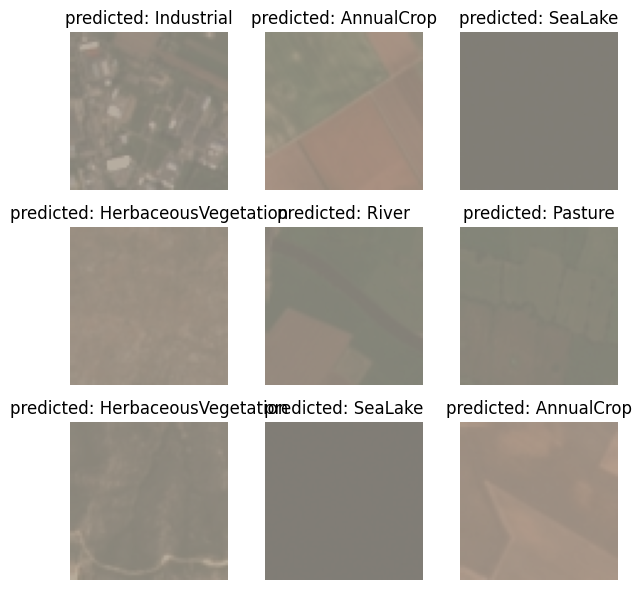

In [26]:
## MobileNetV3 Quantized
model_name = "MobileNetV3"
weights = qmodels.MobileNet_V3_Large_QuantizedWeights.DEFAULT
model_rn = qmodels.mobilenet_v3_large(weights=weights, quantize=True)
num_ftrs = model_rn.classifier[0].in_features
new_model = mobile_net_features(model_rn, num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [27]:
## Save MobileNetV3
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\MobileNetV3.pth
Successfully exported model


## GoogLeNet

In [28]:
## Model Combination Function
def google_net_features(model_fe, num_ftrs):
    # Step 1. Isolate the feature extractor.
    model_fe_features = nn.Sequential(
        model_fe.quant,  # Quantize the input
        model_fe.conv1,
        model_fe.maxpool1,
        model_fe.conv2,
        model_fe.conv3,
        model_fe.maxpool2,
        model_fe.inception3a,
        model_fe.inception3b,
        model_fe.maxpool3,
        model_fe.inception4a,
        model_fe.inception4b,
        model_fe.inception4c,
        model_fe.inception4d,
        model_fe.inception4e,
        model_fe.maxpool4,
        model_fe.inception5a,
        model_fe.inception5b,
        model_fe.avgpool,
        model_fe.dequant,  # Dequantize the output
    )
    # Step 2. Create a new "head"
    new_head = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(num_ftrs, len(class_names)),
    )
    # Step 3. Combine, and don't forget the quant stubs.
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

Epochs:   0%|                                                            | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------
train Loss: 0.6632 Acc: 0.7888


Epochs:   5%|██▍                                              | 1/20 [03:23<1:04:35, 203.98s/it]

val Loss: 0.5937 Acc: 0.8133

Epoch 1/19
----------
train Loss: 0.5689 Acc: 0.8242


Epochs:  10%|████▉                                            | 2/20 [06:41<1:00:01, 200.07s/it]

val Loss: 0.4938 Acc: 0.8387

Epoch 2/19
----------
train Loss: 0.5456 Acc: 0.8348


Epochs:  15%|███████▋                                           | 3/20 [10:05<57:14, 202.05s/it]

val Loss: 0.4885 Acc: 0.8448

Epoch 3/19
----------
train Loss: 0.5254 Acc: 0.8392


Epochs:  20%|██████████▏                                        | 4/20 [13:47<55:55, 209.70s/it]

val Loss: 0.5048 Acc: 0.8394

Epoch 4/19
----------
train Loss: 0.5208 Acc: 0.8401


Epochs:  25%|████████████▊                                      | 5/20 [17:09<51:45, 207.01s/it]

val Loss: 0.4759 Acc: 0.8465

Epoch 5/19
----------
train Loss: 0.5370 Acc: 0.8395


Epochs:  30%|███████████████▎                                   | 6/20 [20:38<48:27, 207.67s/it]

val Loss: 0.6070 Acc: 0.8300

Epoch 6/19
----------
train Loss: 0.5091 Acc: 0.8452


Epochs:  35%|█████████████████▊                                 | 7/20 [24:04<44:51, 207.06s/it]

val Loss: 0.5399 Acc: 0.8383

Epoch 7/19
----------
train Loss: 0.4174 Acc: 0.8670


Epochs:  40%|████████████████████▍                              | 8/20 [27:23<40:55, 204.66s/it]

val Loss: 0.4068 Acc: 0.8669

Epoch 8/19
----------
train Loss: 0.3971 Acc: 0.8713


Epochs:  45%|██████████████████████▉                            | 9/20 [30:59<38:08, 208.01s/it]

val Loss: 0.3937 Acc: 0.8698

Epoch 9/19
----------
train Loss: 0.3825 Acc: 0.8738


Epochs:  50%|█████████████████████████                         | 10/20 [34:23<34:28, 206.90s/it]

val Loss: 0.3905 Acc: 0.8706

Epoch 10/19
----------
train Loss: 0.3799 Acc: 0.8726


Epochs:  55%|███████████████████████████▌                      | 11/20 [37:48<30:57, 206.38s/it]

val Loss: 0.3909 Acc: 0.8719

Epoch 11/19
----------
train Loss: 0.3851 Acc: 0.8703


Epochs:  60%|██████████████████████████████                    | 12/20 [41:05<27:08, 203.52s/it]

val Loss: 0.3838 Acc: 0.8698

Epoch 12/19
----------
train Loss: 0.3751 Acc: 0.8742


Epochs:  65%|████████████████████████████████▌                 | 13/20 [44:24<23:35, 202.16s/it]

val Loss: 0.3863 Acc: 0.8693

Epoch 13/19
----------
train Loss: 0.3738 Acc: 0.8727


Epochs:  70%|███████████████████████████████████               | 14/20 [48:08<20:52, 208.79s/it]

val Loss: 0.3841 Acc: 0.8693

Epoch 14/19
----------
train Loss: 0.3606 Acc: 0.8790


Epochs:  75%|█████████████████████████████████████▌            | 15/20 [51:23<17:02, 204.56s/it]

val Loss: 0.3806 Acc: 0.8709

Epoch 15/19
----------
train Loss: 0.3685 Acc: 0.8737


Epochs:  80%|████████████████████████████████████████          | 16/20 [54:43<13:33, 203.27s/it]

val Loss: 0.3779 Acc: 0.8731

Epoch 16/19
----------
train Loss: 0.3708 Acc: 0.8741


Epochs:  85%|██████████████████████████████████████████▌       | 17/20 [58:29<10:30, 210.11s/it]

val Loss: 0.3766 Acc: 0.8728

Epoch 17/19
----------
train Loss: 0.3678 Acc: 0.8765


Epochs:  90%|███████████████████████████████████████████▏    | 18/20 [1:01:51<06:55, 207.65s/it]

val Loss: 0.3763 Acc: 0.8722

Epoch 18/19
----------
train Loss: 0.3674 Acc: 0.8765


Epochs:  95%|█████████████████████████████████████████████▌  | 19/20 [1:05:26<03:29, 209.92s/it]

val Loss: 0.3765 Acc: 0.8724

Epoch 19/19
----------
train Loss: 0.3579 Acc: 0.8787


Epochs: 100%|████████████████████████████████████████████████| 20/20 [1:09:08<00:00, 207.42s/it]

val Loss: 0.3771 Acc: 0.8720

Training complete in 69m 8s
Best val Acc: 0.873148


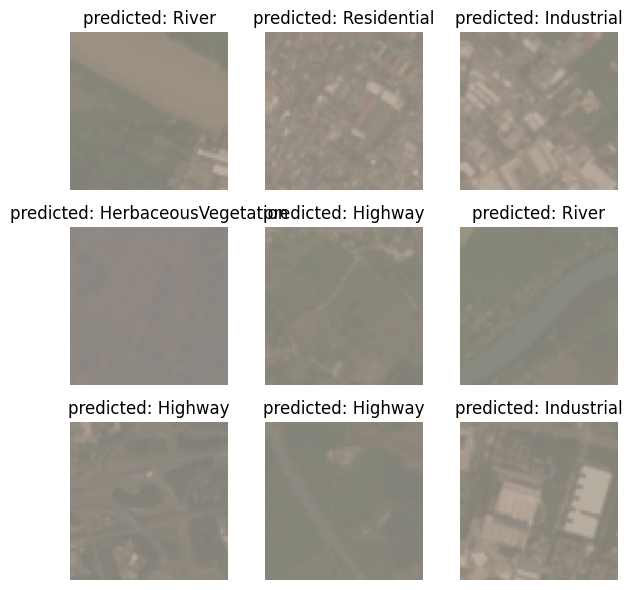

In [29]:
## GoogLeNet Quantized
model_name = "GoogLeNet"
weights = qmodels.GoogLeNet_QuantizedWeights.DEFAULT
model_rn = qmodels.googlenet(weights=weights, quantize=True)
num_ftrs = model_rn.fc.in_features
new_model = google_net_features(model_rn,num_ftrs)
new_model = new_model.to('cpu')
criterion, optimizer_ft, exp_lr_scheduler = Optimizer_Setup(new_model)
new_model = train_model(model_name, new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=epochs, device='cpu')
visualize_model(new_model)
plt.tight_layout()

In [30]:
## Save GoogLeNet Quantized
save_model(new_model, model_name)
export_onnx(model_name, new_model, batch_size)

Saving model to: models\GoogLeNet.pth
Successfully exported model


## Stats

In [31]:
stats = pd.DataFrame(stats_lst, columns = ['Model', 'Epoch', 'Train Loss', 'Val Accuracy', 'Val Loss', 'Val Accuracy'])

In [32]:
stats.to_csv('Stats.csv')